In [1]:
!pip3 install pyro-ppl

In [2]:
import os
import pyro
import pyro.distributions as dist
import torch

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import json # Added for parsing JSON
from sklearn.preprocessing import MultiLabelBinarizer # Added for one-hot encoding
from sklearn.model_selection import train_test_split

import math
import torch.nn as nn
import torch.nn.functional as F
from pyro.infer import SVI, TraceMeanField_ELBO
from tqdm import trange

import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
def load_data(folder_path: str) -> pd.DataFrame:
    # Columns to keep
    use_columns = ['movie_name', 'genre', 'description']

    # Get all CSV files in the folder
    csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

    # Load each CSV with only the desired columns
    df_list = [
        pd.read_csv(os.path.join(folder_path, file), usecols=lambda col: col in use_columns)
        for file in csv_files
    ]

    # Combine into a single DataFrame
    combined_df = pd.concat(df_list, ignore_index=True)
    return combined_df

def clean_data_set(df, threshold) -> pd.DataFrame:
  # Count the occurrences of each description
  desc_counts = df['description'].value_counts()

  # Get the descriptions that appear more than once
  repeated_descriptions = desc_counts[desc_counts > threshold].index

  # Remove rows where description is in repeated_descriptions
  df = df[~df['description'].isin(repeated_descriptions)]

  print("Removed descriptions that appeared more than once:")

  return df

def filter_and_adjust_genres(df: pd.DataFrame, allowed_genres: list) -> pd.DataFrame:
    """
    Filters a DataFrame to keep rows with at least one allowed genre
    and adjusts the 'genres' list in each row to only contain allowed genres.

    Args:
        df: Pandas DataFrame with a 'genres' column containing lists of strings.
        allowed_genres: A list of strings representing the allowed genres.

    Returns:
        A new Pandas DataFrame with rows filtered and 'genres' lists adjusted.
    """
    # Ensure allowed_genres is a set for efficient lookup
    allowed_genres_set = set(allowed_genres)

    # Create a boolean mask for rows that have at least one allowed genre
    # and also create the new list of genres for each row
    new_genres_list = []
    rows_to_keep_mask = []

    for genre_list in df['genre']:
        if isinstance(genre_list, list):
            valid_genres_in_row = [genre for genre in genre_list if genre in allowed_genres_set]
            if valid_genres_in_row: # If there's at least one valid genre
                rows_to_keep_mask.append(True)
                new_genres_list.append(valid_genres_in_row)
            else:
                rows_to_keep_mask.append(False)
                new_genres_list.append([]) # Keep structure, though this row will be dropped
        else:
            # Handle cases where a row might not have a list (e.g., NaN or other types)
            rows_to_keep_mask.append(False)
            new_genres_list.append([])

    # Apply the mask to filter rows
    filtered_df = df[rows_to_keep_mask].copy() # Use .copy() to avoid SettingWithCopyWarning

    # Update the 'genres' column in the filtered DataFrame
    # We need to assign the new_genres_list only for the rows that were kept.
    # Re-filter the new_genres_list based on the mask before assigning.
    filtered_new_genres = [genres for keep, genres in zip(rows_to_keep_mask, new_genres_list) if keep]
    filtered_df['genre'] = filtered_new_genres

    return filtered_df

In [5]:
# Load the dataset and drop nans
df = load_data('/content/drive/MyDrive/MBMLProject/Data')

# Clean the dataset by dropping entries with missing values
movies_prior_to_cleaning = df.shape[0]
df.dropna(subset=['description', 'movie_name', 'genre'], inplace=True)
df = clean_data_set(df, 1)

# Define established genres
#genre_list = ['Action', 'Adventure','Crime', 'Family', 'Fantasy',
#       'History', 'Horror', 'Mystery', 'Romance', 'Sci-Fi', 'Sport',
#       'Thriller', 'War']

genre_list = ['Action', 'Adventure', 'Fantasy', 'Horror', 'Romance', 'Sci-Fi', 'Sport','Thriller', 'War']

# Convert genre format
df['genre'] = df['genre'].apply(lambda x: [genre.strip() for genre in x.split(',')])

# Remove all rows that does not have these genres.
df = filter_and_adjust_genres(df, genre_list)
movies_after_cleaning = df.shape[0]
df.reset_index(drop=True, inplace=True)
print(f"Has removed {movies_prior_to_cleaning-movies_after_cleaning} movies from the dataset, corresponding to {((movies_prior_to_cleaning - movies_after_cleaning) / movies_prior_to_cleaning)*100:.2f}%")


Removed descriptions that appeared more than once:
Has removed 262183 movies from the dataset, corresponding to 74.78%


In [6]:
thriller_rows = df[df['genre'].apply(lambda genres: 'Sci-Fi' in genres)]
thriller_rows

,movie_name,genre,description
51819,Depth of Field,"[Romance, Sci-Fi]",The world has developed a condition that cause...
56504,The Night Realm,"[Fantasy, Romance, Sci-Fi]",All Reese wants for Christmas is two permanent...
57400,Amor Mutante,"[Romance, Sci-Fi]",In an panic-stricken ambience in the city caus...
65617,Don't Look Up,[Sci-Fi],Two low-level astronomers must go on a giant m...
65618,Megalopolis,[Sci-Fi],An architect wants to rebuild New York City as...
...,...,...,...
70002,Project Oak Tree: Disclosure,[Sci-Fi],A parallel universe that mirrors earth in many...
70003,Scarabota,[Sci-Fi],"Year 2085, Captain Harper McTavish of the US S..."
70004,A Matter of Interest %,[Sci-Fi],A band of recently grad students from Princeto...
70005,The Guardian - O Fylakas,[Sci-Fi],"A woman called Lea, goes to sleep and wakes up..."


In [7]:
# Create the index
vectorizer = CountVectorizer(max_df=0.8, min_df=2, max_features= 15000, stop_words='english')
docs = torch.from_numpy(vectorizer.fit_transform(df['description']).toarray())

# Create the vocabulary
vocab = pd.DataFrame(columns=['word', 'index'])
vocab['word'] = vectorizer.get_feature_names_out()
vocab['index'] = vocab.index
print('Dictionary size: %d' % len(vocab))
print('Corpus size: {}'.format(docs.shape))

# One-hot encode the genres
mlb = MultiLabelBinarizer()
genre_onehot = pd.DataFrame(mlb.fit_transform(df['genre']), columns=mlb.classes_, index=df.index)
genre_names = genre_onehot.columns
genre_values = genre_onehot.values
genre = df['genre'].values

Dictionary size: 15000
Corpus size: torch.Size([88423, 15000])


In [8]:
genre_names

Index(['Action', 'Adventure', 'Fantasy', 'Horror', 'Romance', 'Sci-Fi',
       'Sport', 'Thriller', 'War'],
      dtype='object')

In [9]:
train_docs, test_docs, train_genre, test_genre, train_index, test_index = train_test_split(docs, genre_values, df.index, test_size=0.2, random_state=42, shuffle=True)
# convert to float32
train_docs = train_docs.to(torch.float32).to(device)
test_docs = test_docs.to(torch.float32).to(device)
train_genre = torch.from_numpy(train_genre).to(torch.float32).to(device)
test_genre = torch.from_numpy(test_genre).to(torch.float32)

In [10]:
class Encoder(nn.Module):
    # Base class for the encoder net, used in the guide
    def __init__(self, vocab_size, num_topics, hidden, dropout):
        super().__init__()
        self.drop = nn.Dropout(dropout)  # to avoid component collapse
        self.fc1 = nn.Linear(vocab_size, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fcmu = nn.Linear(hidden, num_topics)
        self.fclv = nn.Linear(hidden, num_topics)
        # NB: here we set `affine=False` to reduce the number of learning parameters
        # See https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html
        # for the effect of this flag in BatchNorm1d
        self.bnmu = nn.BatchNorm1d(num_topics, affine=False)  # to avoid component collapse
        self.bnlv = nn.BatchNorm1d(num_topics, affine=False)  # to avoid component collapse

    def forward(self, inputs):
        h = F.softplus(self.fc1(inputs))
        h = F.softplus(self.fc2(h))
        h = self.drop(h)
        # μ and Σ are the outputs
        logtheta_loc = self.bnmu(self.fcmu(h))
        logtheta_logvar = self.bnlv(self.fclv(h))
        logtheta_scale = (0.5 * logtheta_logvar).exp()  # Enforces positivity
        return logtheta_loc, logtheta_scale

class Decoder(nn.Module):
    # Base class for the decoder net, used in the model
    def __init__(self, vocab_size, num_topics, dropout):
        super().__init__()
        self.beta = nn.Linear(num_topics, vocab_size, bias=False)
        self.bn = nn.BatchNorm1d(vocab_size, affine=False)
        self.drop = nn.Dropout(dropout)

    def forward(self, inputs):
        inputs = self.drop(inputs)
        # the output is σ(βθ)
        return F.softmax(self.bn(self.beta(inputs)), dim=1)

class GenrePredictor(nn.Module):
    # Module for predicting genres from topic distributions
    def __init__(self, num_topics, num_genres, hidden_dim, dropout):
        super().__init__()
        self.beta_topic = nn.Linear(num_topics, num_genres, bias=False)
        self.bn_topic = nn.BatchNorm1d(num_genres, affine=False)
        self.drop_topic = nn.Dropout(dropout)

    def forward(self, theta):
        inputs = self.drop_topic(theta)
        return F.sigmoid(self.bn_topic(self.beta_topic(inputs)))

class ProdLDA(nn.Module):
    def __init__(self, vocab_size, num_topics, hidden, dropout, num_genres=None, hidden_dim_genre=100):
        super().__init__()
        self.vocab_size = vocab_size
        self.num_topics = num_topics
        self.num_genres = num_genres
        self.encoder = Encoder(vocab_size, num_topics, hidden, dropout)
        self.decoder = Decoder(vocab_size, num_topics, dropout)

        # Add genre predictor if num_genres is provided
        if num_genres is not None:
            self.genre_predictor = GenrePredictor(num_topics, num_genres, hidden_dim_genre, dropout)
        else:
            self.genre_predictor = None

    def model(self, docs, genres=None):
        pyro.module("decoder", self.decoder)
        if self.genre_predictor is not None:
            pyro.module("genre_predictor", self.genre_predictor)

        with pyro.plate("documents", docs.shape[0]):
            # Dirichlet prior 𝑝(𝜃|𝛼) is replaced by a logistic-normal distribution
            logtheta_loc = docs.new_zeros((docs.shape[0], self.num_topics))
            logtheta_scale = docs.new_ones((docs.shape[0], self.num_topics))
            logtheta = pyro.sample(
                "logtheta", dist.Normal(logtheta_loc, logtheta_scale).to_event(1))
            theta = F.softmax(logtheta, -1)

            # conditional distribution of 𝑤𝑛 is defined as
            # 𝑤𝑛|𝛽,𝜃 ~ Categorical(𝜎(𝛽𝜃))
            count_param = self.decoder(theta)
            total_count = int(docs.sum(-1).max())
            pyro.sample(
                'obs',
                dist.Multinomial(total_count, count_param),
                obs=docs
            )

            # Genre prediction if genres are provided
            if genres is not None and self.genre_predictor is not None:
                genre_probs = self.genre_predictor(theta)
                # For each genre dimension, use a Bernoulli distribution
                # since genres are one-hot encoded (multi-label classification)
                for i in range(self.num_genres):
                    pyro.sample(
                        f"genre_{i}",
                        dist.Bernoulli(genre_probs[:, i]),
                        obs=genres[:, i]
                    )
    def guide(self, docs, genres=None):
        pyro.module("encoder", self.encoder)
        with pyro.plate("documents", docs.shape[0]):
            # Dirichlet prior 𝑝(𝜃|𝛼) is replaced by a logistic-normal distribution,
            # where μ and Σ are the encoder network outputs
            logtheta_loc, logtheta_scale = self.encoder(docs)
            logtheta = pyro.sample(
                "logtheta", dist.Normal(logtheta_loc, logtheta_scale).to_event(1))

    def beta(self):
        # beta matrix elements are the weights of the FC layer on the decoder
        return self.decoder.beta.weight.cpu().detach().T

    def beta_topic(self):
      return self.genre_predictor.beta_topic.weight.cpu().detach().T

    def predict_genres(self, docs):
        """
        Predict genres for the given documents

        Args:
            docs: Document word counts tensor

        Returns:
            genre_probs: Probabilities for each genre class
        """
        if self.genre_predictor is None:
            raise ValueError("Genre predictor not initialized. Set num_genres when creating the model.")

        # Get the topic proportions using the encoder
        with torch.no_grad():
            logtheta_loc, _ = self.encoder(docs)
            theta = F.softmax(logtheta_loc, dim=-1)

            # Get genre probabilities using the genre predictor
            genre_probs = self.genre_predictor(theta)

        return genre_probs


In [11]:
# setting global variables
seed = 0
torch.manual_seed(seed)
pyro.set_rng_seed(seed)
num_topics = 15
docs = docs.float().to(device)
batch_size = 128
learning_rate = 1e-3
num_epochs = 20

In [12]:
# clear parameters
pyro.clear_param_store()

# Update model initialization with number of genres
prodLDA = ProdLDA(
    vocab_size=docs.shape[1],
    num_topics=num_topics,
    hidden=100,
    dropout=0.2,
    num_genres=genre_onehot.shape[1],  # Number of genre classes
    hidden_dim_genre=100
)
prodLDA.to(device)

ProdLDA(
  (encoder): Encoder(
    (drop): Dropout(p=0.2, inplace=False)
    (fc1): Linear(in_features=15000, out_features=100, bias=True)
    (fc2): Linear(in_features=100, out_features=100, bias=True)
    (fcmu): Linear(in_features=100, out_features=15, bias=True)
    (fclv): Linear(in_features=100, out_features=15, bias=True)
    (bnmu): BatchNorm1d(15, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (bnlv): BatchNorm1d(15, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  )
  (decoder): Decoder(
    (beta): Linear(in_features=15, out_features=15000, bias=False)
    (bn): BatchNorm1d(15000, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (drop): Dropout(p=0.2, inplace=False)
  )
  (genre_predictor): GenrePredictor(
    (beta_topic): Linear(in_features=15, out_features=9, bias=False)
    (bn_topic): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (drop_topic): Dropout(p=0.2, inplace=False)


In [13]:
optimizer = pyro.optim.Adam({"lr": learning_rate})

svi = SVI(prodLDA.model, prodLDA.guide, optimizer, loss=TraceMeanField_ELBO())
num_batches = int(math.ceil(train_docs.shape[0] / batch_size))

bar = trange(num_epochs)
for epoch in bar:
    running_loss = 0.0
    for i in range(num_batches):
        batch_docs = train_docs[i * batch_size:(i + 1) * batch_size, :]
        batch_genres = train_genre[i * batch_size:(i + 1) * batch_size, :]
        loss = svi.step(batch_docs, batch_genres)
        running_loss += loss / batch_docs.size(0)

    predictions = prodLDA.predict_genres(test_docs.to(torch.float32))
    # Convert predictions to binary (0 or 1) based on a threshold
    genre_preds = (predictions > 0.5).float().cpu().numpy()
    # Calculate accuracy
    accuracy = (test_genre == genre_preds).to(float).mean()
    print("Epoch {}: Accuracy: {:.2f}%".format(epoch, accuracy * 100))
    bar.set_postfix(epoch_loss='{:.2e}'.format(running_loss))

  5%|▌         | 1/20 [00:15<04:51, 15.32s/it, epoch_loss=7.21e+04]

Epoch 0: Accuracy: 54.88%


 10%|█         | 2/20 [00:29<04:26, 14.83s/it, epoch_loss=6.93e+04]

Epoch 1: Accuracy: 60.12%


 15%|█▌        | 3/20 [00:43<04:06, 14.50s/it, epoch_loss=6.80e+04]

Epoch 2: Accuracy: 64.67%


 20%|██        | 4/20 [00:57<03:46, 14.17s/it, epoch_loss=6.71e+04]

Epoch 3: Accuracy: 66.50%


 25%|██▌       | 5/20 [01:10<03:26, 13.76s/it, epoch_loss=6.65e+04]

Epoch 4: Accuracy: 68.60%


 30%|███       | 6/20 [01:23<03:08, 13.44s/it, epoch_loss=6.58e+04]

Epoch 5: Accuracy: 68.84%


 35%|███▌      | 7/20 [01:36<02:53, 13.32s/it, epoch_loss=6.52e+04]

Epoch 6: Accuracy: 69.93%


 40%|████      | 8/20 [01:49<02:38, 13.24s/it, epoch_loss=6.47e+04]

Epoch 7: Accuracy: 69.45%


 45%|████▌     | 9/20 [02:02<02:25, 13.24s/it, epoch_loss=6.41e+04]

Epoch 8: Accuracy: 70.10%


 50%|█████     | 10/20 [02:16<02:13, 13.31s/it, epoch_loss=6.37e+04]

Epoch 9: Accuracy: 70.17%


 55%|█████▌    | 11/20 [02:29<02:00, 13.40s/it, epoch_loss=6.35e+04]

Epoch 10: Accuracy: 70.07%


 60%|██████    | 12/20 [02:43<01:47, 13.48s/it, epoch_loss=6.34e+04]

Epoch 11: Accuracy: 70.51%


 65%|██████▌   | 13/20 [02:57<01:34, 13.48s/it, epoch_loss=6.33e+04]

Epoch 12: Accuracy: 70.92%


 70%|███████   | 14/20 [03:10<01:21, 13.57s/it, epoch_loss=6.32e+04]

Epoch 13: Accuracy: 70.83%


 75%|███████▌  | 15/20 [03:24<01:08, 13.64s/it, epoch_loss=6.31e+04]

Epoch 14: Accuracy: 71.09%


 80%|████████  | 16/20 [03:38<00:54, 13.69s/it, epoch_loss=6.31e+04]

Epoch 15: Accuracy: 71.42%


 85%|████████▌ | 17/20 [03:52<00:41, 13.74s/it, epoch_loss=6.30e+04]

Epoch 16: Accuracy: 71.24%


 90%|█████████ | 18/20 [04:05<00:27, 13.58s/it, epoch_loss=6.30e+04]

Epoch 17: Accuracy: 71.75%


 95%|█████████▌| 19/20 [04:18<00:13, 13.43s/it, epoch_loss=6.29e+04]

Epoch 18: Accuracy: 71.69%


100%|██████████| 20/20 [04:31<00:00, 13.58s/it, epoch_loss=6.29e+04]

Epoch 19: Accuracy: 72.00%


In [14]:
torch.save(prodLDA.state_dict(), "model_params_topic_15_epoch_20.pt")

In [ ]:
"""
state_dict = torch.load("model_params_topic_15_epoch_20.pt", weights_only=True)
pyro.clear_param_store()
prodLDA = ProdLDA(
    vocab_size=docs.shape[1],
    num_topics=num_topics,
    hidden=100,
    dropout=0.2,
    num_genres=genre_onehot.shape[1],  # Number of genre classes
    hidden_dim_genre=100
)
prodLDA.to(device)
"""

<All keys matched successfully>

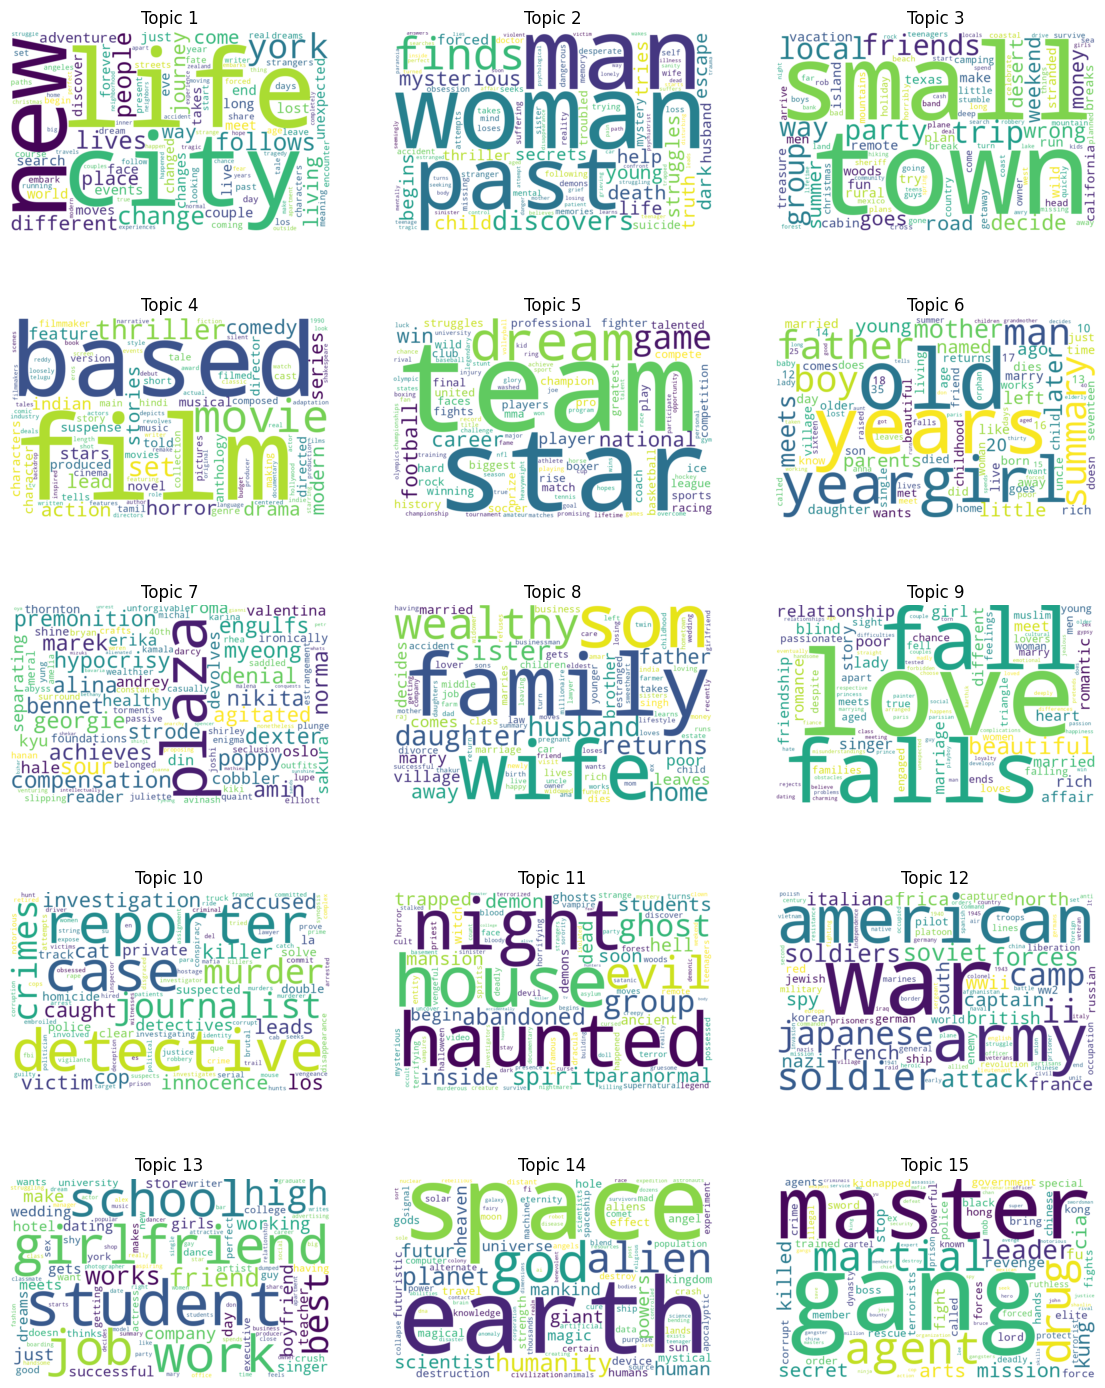

In [16]:
def plot_word_cloud(b, ax, v, n):
    sorted_, indices = torch.sort(b, descending=True)
    df = pd.DataFrame(indices[:100].numpy(), columns=['index'])
    words = pd.merge(df, vocab[['index', 'word']],
                     how='left', on='index')['word'].values.tolist()
    sizes = (sorted_[:100] * 1000).int().numpy().tolist()
    freqs = {words[i]: sizes[i] for i in range(len(words))}
    wc = WordCloud(background_color="white", width=800, height=500)
    wc = wc.generate_from_frequencies(freqs)
    ax.set_title('Topic %d' % (n + 1))
    ax.imshow(wc, interpolation='bilinear')
    ax.axis("off")

beta = prodLDA.beta()
fig, axs = plt.subplots(5, 3, figsize=(14, 18))
for n in range(beta.shape[0]):
    i, j = divmod(n, 3)
    plot_word_cloud(beta[n], axs[i, j], vocab, n)
axs[-1, -1].axis('off');

plt.show()

## Topic Mapping to Movie Genres


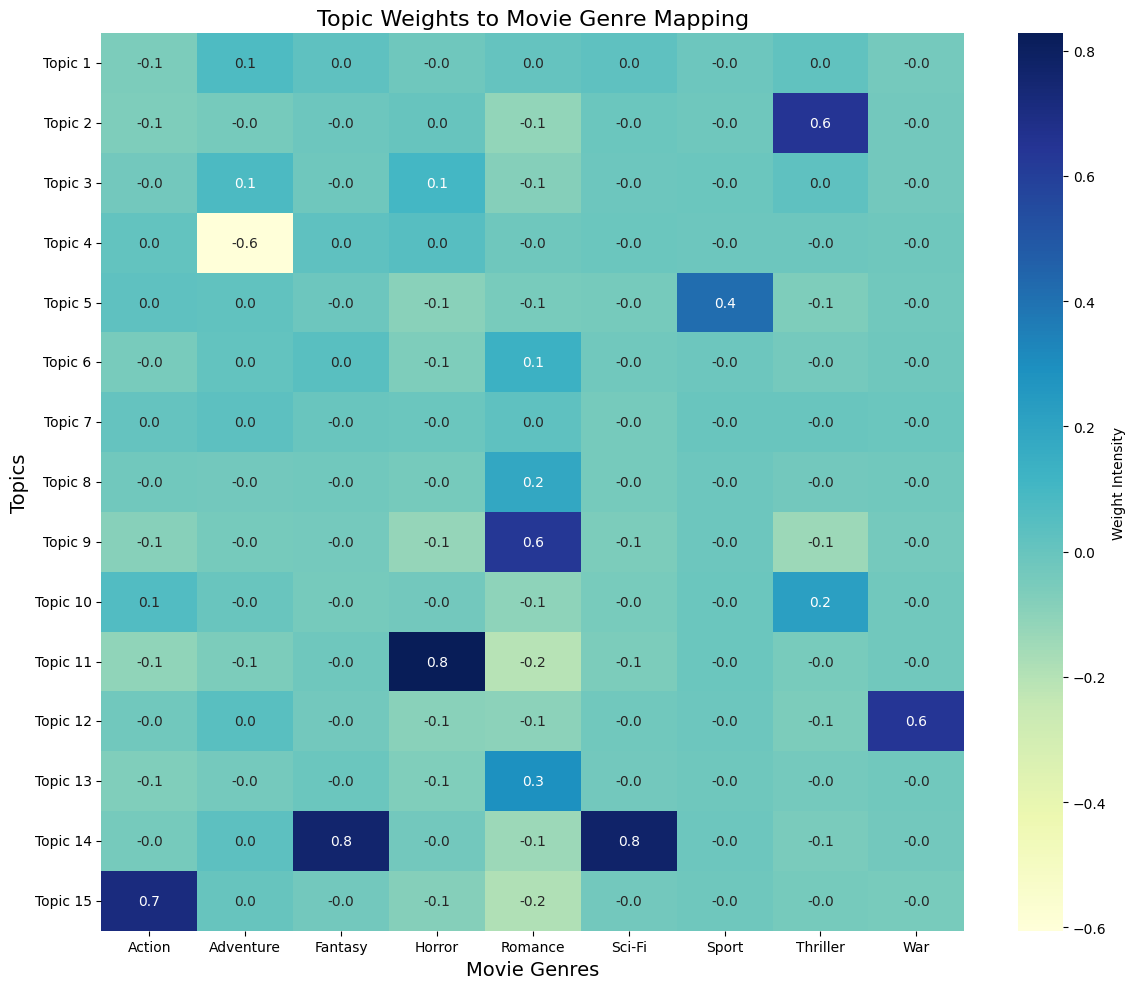

In [17]:
# Extract mapping from model
beta_topic = prodLDA.beta_topic()

# Create topic labels
topic_labels = [f"Topic {i+1}" for i in range(num_topics)]

# Create the heatmap
plt.figure(figsize=(12, 10)) # Adjust figure size for better readability

# To change the color theme, modify the 'selected_colormap' string.
# Some popular colormaps: 'viridis', 'plasma', 'inferno', 'magma', 'cividis'
# 'coolwarm', 'RdBu', 'YlGnBu', 'Blues', 'BuPu', 'Greens'
selected_colormap = 'YlGnBu' # Current theme

sns.heatmap(
    beta_topic,
    annot=True,  # Display the weight values on the heatmap cells
    fmt=".1f",   # Format annotations to one decimal place
    cmap=selected_colormap,
    xticklabels=genre_names,
    yticklabels=topic_labels,
    cbar=True,  # Ensure the color bar (heatscale) is displayed
    cbar_kws={'label': 'Weight Intensity'} # Label for the color bar
)

# Set x-axis and y-axis labels
plt.xlabel("Movie Genres", fontsize=14)
plt.ylabel("Topics", fontsize=14)

# Add a title to the heatmap
plt.title("Topic Weights to Movie Genre Mapping", fontsize=16)

# Ensure labels are not cut off
plt.tight_layout()

# Save the heatmap to a file
file_path = "topic_genre_heatmap.png"
plt.savefig(file_path)

plt.show()


In [18]:
# Evaluate genre prediction performance
from sklearn.metrics import f1_score, precision_score, recall_score

# Predict genres
genre_probs = prodLDA.predict_genres(test_docs)
genre_preds = (genre_probs > 0.5).float().cpu().numpy()
genre_true = test_genre.cpu().numpy()

# Calculate metrics (micro-averaged for multi-label classification)
f1 = f1_score(genre_true, genre_preds, average='micro')
precision = precision_score(genre_true, genre_preds, average='micro')
recall = recall_score(genre_true, genre_preds, average='micro')

print(f"Genre Prediction Metrics:")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

In [ ]:
beta_topic = prodLDA.genre_predictor.beta_topic.weight.cpu().detach().T
print(beta_topic.shape)
print(torch.argsort(beta_topic[8,:], descending=True))
print(genre_onehot.columns[0])

In [ ]:
test_index[0]

In [ ]:
# Visualize genre predictions for a few example documents

import matplotlib.pyplot as plt

num_examples = 5
num_genres_to_show = min(10, genre_onehot.shape[1])

# Get genre predictions
genre_probs = prodLDA.predict_genres(test_docs[:num_examples])

plt.figure(figsize=(15, 4*num_examples))
for i in range(num_examples):
    # Get the movie overview for context
    overview = df['description'].iloc[test_index[i]]
    movie_title = df['movie_name'].iloc[test_index[i]] if 'movie_name' in df.columns else f"Movie {i+1}"
    # Get actual genres for this movie
    actual_genres = df['genre'].iloc[test_index[i]]

    # Get top predicted genres
    probs = genre_probs[i].cpu().numpy()
    indices = np.argsort(probs)[-num_genres_to_show:]
    genre_names = genre_onehot.columns[indices]
    genre_probabilities = probs[indices]

    # Plot
    plt.subplot(num_examples, 1, i+1)
    bars = plt.barh(genre_names, genre_probabilities)

    # Highlight actual genres
    for j, genre in enumerate(genre_names):
        if genre in actual_genres:
            bars[j].set_color('green')

    plt.xlim(0, 1)
    plt.title(f"Movie: {movie_title}")
    plt.xlabel('Probability')
    plt.ylabel('Genre')

    # Add overview as text (truncated if too long)
    if len(overview) > 200:
        overview = overview[:200] + "..."
    plt.figtext(0.5, (i+0.85)/num_examples, f"Overview: {overview}",
                ha='center', fontsize=8, bbox={"facecolor":"lightgrey", "alpha":0.5})

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle("Genre Predictions (Green = Actual Genre)", fontsize=16)
plt.subplots_adjust(hspace=0.6)
plt.show()